In [2]:
import numpy as np
from numpy.linalg import eig
from matplotlib import pyplot as plt

In [45]:
class op:
    sx = np.array([
        [0,1],
        [1,0]
        ])
    sy = np.array([
        [0,-1j],
        [1j,0]
        ])
    sz = np.array([
        [1,0],
        [0,-1]
        ])
    Id = np.array([
        [1,0],
        [0,1]
        ])

    @staticmethod
    def dag(A):
        return np.conj(A.T)
    
    @staticmethod
    def n_fold_kron(tab):
        ans = 1
        dim = len(tab)
        for i in range(dim):
            ans = np.kron(ans,tab[i])
        return ans


In [24]:
class Ising_sim:
    def __init__(self,dim,**kwargs):
        self.dim = dim
        self.S_ = self.Spins()
        self.H_ = self.Hamiltonian(**kwargs)

    def Spins(self):
        s_ = lambda x_ : [op.n_fold_kron([op.Id for _ in range(j)] + [x_] + [op.Id for _ in range(j+1,self.dim)]) for j in range(self.dim)]
        return (s_(op.sx),s_(op.sy),s_(op.sz))
    
    def Hamiltonian(self,**kwargs):
        J = kwargs.get("J",1)
        h = kwargs.get("h",0)
        left = - h * sum(self.S_[2][i] for i in range(self.dim))
        right = J * sum(sum(self.S_[k][i] @ self.S_[k][(i+1)%self.dim] for i in range(self.dim)) for k in range(3))
        return left + right
    
    def Get_data(self,**kwargs):
        T0 = kwargs.get("T0",0.001)
        Tk = kwargs.get("Tk",10)
        T = np.arange(T0,Tk,0.1)
        E = np.real(eig(self.H_)[0])
        U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
        U_internal = np.vectorize(U_)(T)
        Cp = np.gradient(U_internal)
        return T,U_internal,Cp

C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\750519749.py:23: RuntimeWarning: overflow encountered in exp
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\750519749.py:23: RuntimeWarning: invalid value encountered in scalar divide
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))


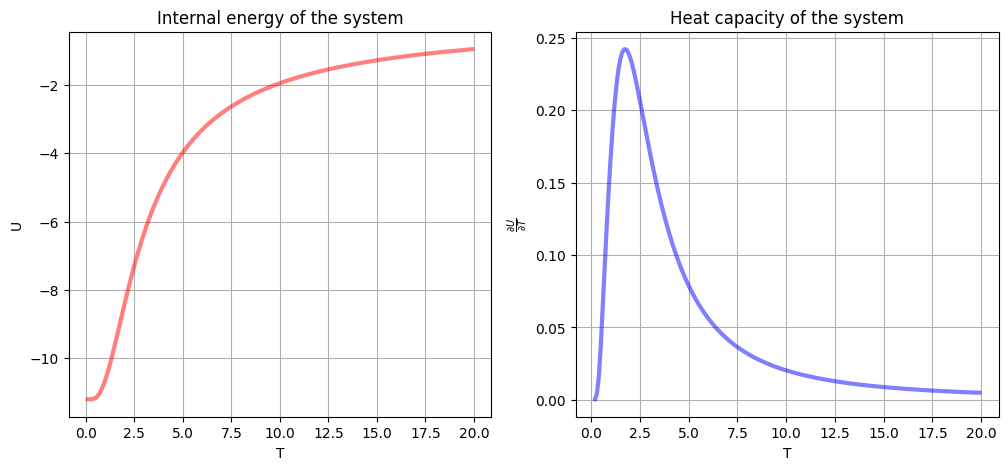

In [25]:
model = Ising_sim(6,**{ "J" : 1, "J2" : 0})
T,U,Cp = model.Get_data(**{"Tk" : 20})

fig = plt.figure(figsize = (12,5))

ax = fig.add_subplot(1,2,1)
ax.plot(T,U,color = "red",alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel("U")
ax.set_title("Internal energy of the system")
ax.grid(True)

ax = fig.add_subplot(1,2,2)
ax.plot(T,Cp,color = "blue", alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel(r"$\frac{\partial U}{\partial T}$")
ax.set_title("Heat capacity of the system")
ax.grid(True)

plt.show()


In [26]:
class Ising_sim_star(Ising_sim):
    def Hamiltonian(self,**kwargs):
        J2 = kwargs.get("J2",kwargs.get("J",1))
        h = kwargs.get("h",0)
        H0 = np.kron(super().Hamiltonian(**kwargs),np.eye(2**self.dim))
        H1 = J2 * sum(sum(np.kron(self.S_[k][i],(self.S_[k][i]+self.S_[k][(i+1)%self.dim])) for i in range(self.dim)) for k in range(3))
        H2 = - h * sum(np.kron(np.eye(2**self.dim),self.S_[2][i]) for i in range(self.dim))
        return H0 + H1 + H2 


        

C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\750519749.py:23: RuntimeWarning: overflow encountered in exp
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\750519749.py:23: RuntimeWarning: invalid value encountered in scalar divide
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))


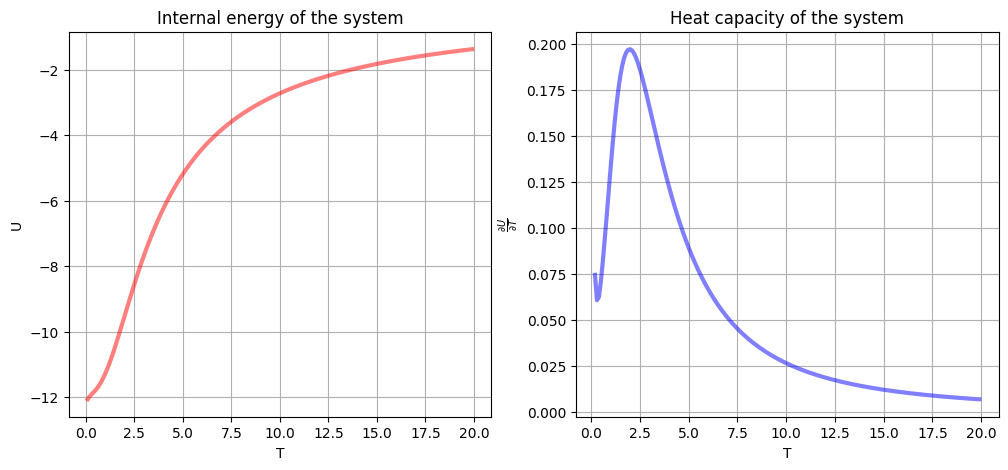

In [27]:
model = Ising_sim_star(6,**{ "J" : 1, "J2" : 0.5})
T,U,Cp = model.Get_data(**{"Tk" : 20})

fig = plt.figure(figsize = (12,5))

ax = fig.add_subplot(1,2,1)
ax.plot(T,U,color = "red",alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel("U")
ax.set_title("Internal energy of the system")
ax.grid(True)

ax = fig.add_subplot(1,2,2)
ax.plot(T,Cp,color = "blue", alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel(r"$\frac{\partial U}{\partial T}$")
ax.set_title("Heat capacity of the system")
ax.grid(True)

plt.show()


In [11]:
J2 = np.arange(0,1.1,0.05)
U_ = []
Cp_ = []
for j2 in J2:
    model = Ising_sim_star(6,**{ "J" : 1, "J2" : j2})
    T,U,Cp = model.Get_data(**{"Tk" : 20})
    U_.append(U)
    Cp_.append(Cp)

C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\699987498.py:23: RuntimeWarning: overflow encountered in exp
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\699987498.py:23: RuntimeWarning: invalid value encountered in scalar divide
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
C:\Users\stemp\AppData\Local\Temp\ipykernel_29124\699987498.py:23: RuntimeWarning: overflow encountered in matmul
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))


In [13]:
np.save("U.npy",np.vstack(U_))
np.save("Cp.npy",np.vstack(Cp_))

In [16]:
cp2 = np.load("Cp.npy")
print(cp2)

[[       nan        nan 0.00059768 0.00514375 0.01847663 0.04089026
  0.06805017 0.095854   0.12230976 0.14676247 0.16892586 0.18849418
  0.20514595 0.21865224 0.22894785 0.23613934 0.24047036 0.2422714
  0.24191197 0.23976369 0.23617605 0.23146286 0.22589667 0.21970839
  0.21308981 0.20619771 0.19915848 0.19207262 0.18501899 0.17805851
  0.17123745 0.1645901  0.15814111 0.15190741 0.14589972 0.14012392
  0.13458204 0.12927318 0.12419414 0.11934002 0.11470469 0.11028109
  0.10606157 0.10203811 0.09820248 0.09454638 0.09106159 0.08774
  0.08457367 0.08155495 0.0786764  0.0759309  0.07331163 0.07081207
  0.068426   0.06614752 0.06397102 0.06189118 0.05990296 0.05800161
  0.0561826  0.05444169 0.05277486 0.0511783  0.04964843 0.04818187
  0.04677542 0.04542608 0.04413099 0.04288747 0.04169299 0.04054516
  0.03944172 0.03838053 0.03735959 0.03637698 0.03543091 0.03451967
  0.03364165 0.03279534 0.0319793  0.03119215 0.0304326  0.02969944
  0.0289915  0.02830768 0.02764694 0.02700829 0.0263

C:\Users\stemp\AppData\Local\Temp\ipykernel_10704\699987498.py:23: RuntimeWarning: overflow encountered in exp
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))
C:\Users\stemp\AppData\Local\Temp\ipykernel_10704\699987498.py:23: RuntimeWarning: invalid value encountered in scalar divide
  U_ = lambda T_ : E @ np.exp(-E/T_) / sum(np.exp(-E/T_))


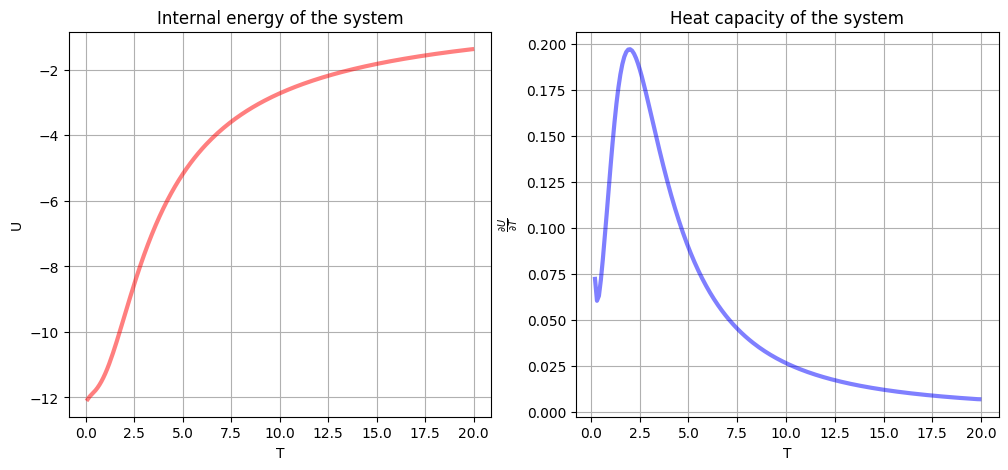

In [10]:
model = Ising_sim_star(6,**{ "J" : 1, "J2" : 1/2})
T,U,Cp = model.Get_data(**{"Tk" : 20})

fig = plt.figure(figsize = (12,5))

ax = fig.add_subplot(1,2,1)
ax.plot(T,U,color = "red",alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel("U")
ax.set_title("Internal energy of the system")
ax.grid(True)

ax = fig.add_subplot(1,2,2)
ax.plot(T,Cp,color = "blue", alpha = 0.5,lw = 3)
ax.set_xlabel("T")
ax.set_ylabel(r"$\frac{\partial U}{\partial T}$")
ax.set_title("Heat capacity of the system")
ax.grid(True)

plt.show()

In [29]:
Cp = np.load("Cp.npy")

In [30]:
Cp.shape

(22, 200)

In [31]:
U = np.load("U.npy")

In [32]:
U.shape

(22, 200)

In [33]:
m,n = Cp.shape
T = np.arange(0.01,10,0.05)

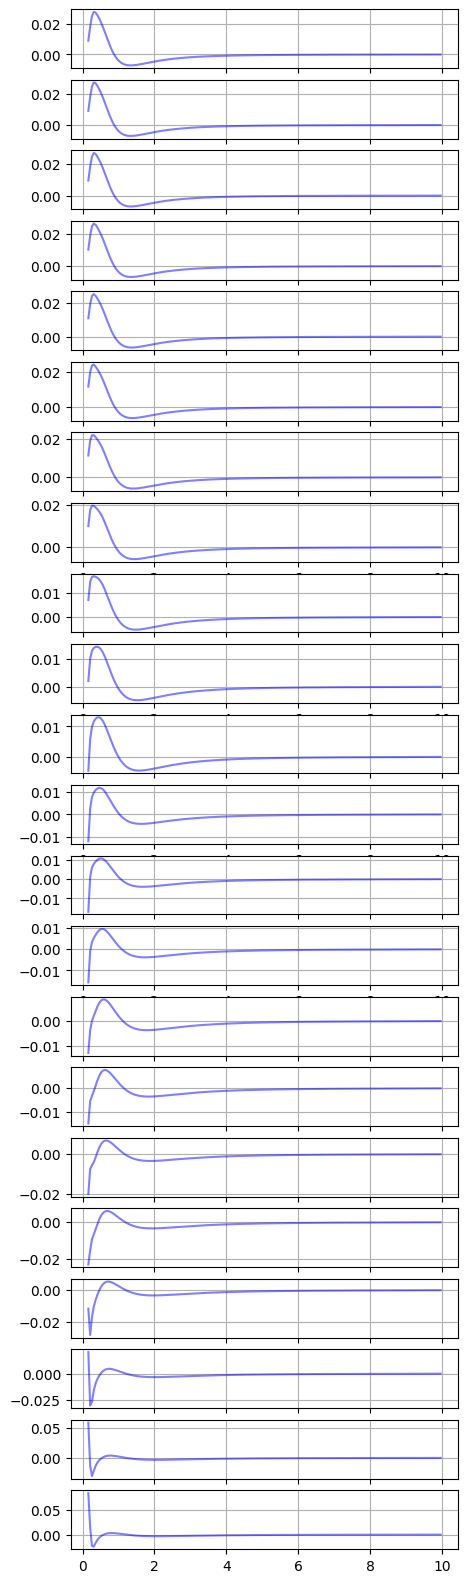

In [46]:
fig = plt.figure(figsize = (5,20))
peaks = []
for i in range(m):
    ax = fig.add_subplot(m,1,i+1)
    grad = np.gradient(Cp[i])
    ax.plot(T,np.gradient(Cp[i]),color = "blue",alpha = 0.5)
    ax.grid(True)
    peaks.append(grad[1:] * grad[:-1] < 0)
plt.show()

In [58]:
T_ = (T[1:] + T[:-1])/2
peaks_num = []
for peak in peaks:
    peaks_num.append(T_[peak])

print(peaks_num)
print(len(peaks_num))

[array([0.885]), array([0.885]), array([0.885]), array([0.885]), array([0.885]), array([0.885]), array([0.885]), array([0.935]), array([0.935]), array([0.985]), array([0.185, 0.985]), array([0.185, 1.035]), array([0.185, 1.035]), array([0.235, 1.085]), array([0.285, 1.135]), array([0.335, 1.135]), array([0.385, 1.185]), array([0.435, 1.185]), array([0.485, 1.185]), array([0.185, 0.485, 1.185]), array([0.185, 0.535, 1.185]), array([0.235, 0.585, 1.185])]
22


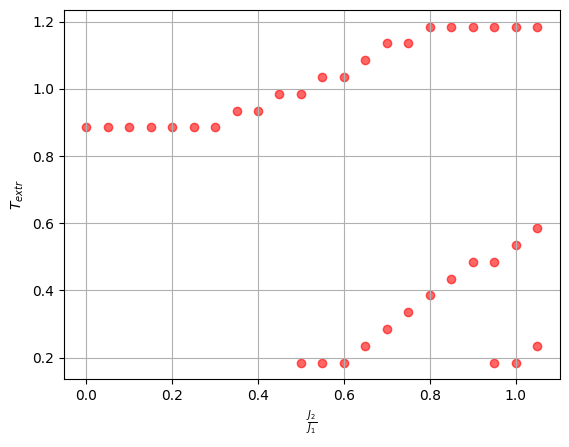

In [60]:
J2 = np.arange(0,1.1,0.05)
fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(peaks_num)):
    for num in peaks_num[i]:
        ax.scatter(J2[i],num,color = "red", alpha=0.6)
ax.grid(True)
ax.set_xlabel(r"$\frac{J_{2}}{J_{1}}$")
ax.set_ylabel(r"$T_{extr}$")
plt.show()
